In [1]:
import gc
import os
import h5py
import pickle
import numpy as np
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
from Haldane_anis_supervise_class import *

In [2]:
L = 5 #number of particles must be odd
bond = 10 # resonable amount
path  = f"./dataset_L={L}_bond={bond}"
os.makedirs(path, exist_ok=True)

In [3]:
points = Haldan_anis(L = L, bond = bond).points()
file_path_train_DMRG = os.path.join(path, 'train_set_DMRG.pkl')
with open(file_path_train_DMRG, "wb") as f:
    pickle.dump(points, f)
gc.collect(2)

Generating train set: 100%|██████████| 185/185 [00:04<00:00, 39.25it/s]


26

In [4]:
test = Haldan_anis(L = L, bond = bond).generate_test_set()
file_path_test = os.path.join(path, 'test_set.pkl')
with open(file_path_test, "wb") as f:
    pickle.dump(test, f)
gc.collect(2)

Generating test set: 100%|██████████| 1600/1600 [00:12<00:00, 128.73it/s]


0

In [5]:
def gram_train_DMRG():

    with open(file_path_train_DMRG, "rb") as f:
        loaded_dataset = pickle.load(f)

    gs = loaded_dataset[0]

    def inner_product(i,j):
        return np.abs(gs[i].H @ gs[j])**2
    
    d = len(gs)
    afinity_train = np.zeros((d,d))

    for idx in range(d*d):
        i = idx // d
        j = idx % d
        if j>=i:
            afinity_train[i,j]=afinity_train[j,i]=inner_product(i,j)

    return afinity_train

g_train = gram_train_DMRG()

file_path_kernel_train_DMRG= os.path.join(path, "kernel_train_Haldane_DMRG.hdf5")
with h5py.File(file_path_kernel_train_DMRG, "w") as f:
    f.create_dataset(" gram_train_DMRG", data = g_train)
    
gc.collect(2)

0

In [6]:
def gram_test_DMRG():

    with open(file_path_test, 'rb') as f:
        loaded_test_set = pickle.load(f)  
    Xte = np.array(loaded_test_set)
    d1 = Xte.shape[0]

    with open(file_path_train_DMRG, "rb") as f:
        loaded_dataset = pickle.load(f)
    Xtr = np.array(loaded_dataset[0])
    d2 = Xtr.shape[0]
      
    gram_matrix_test = np.zeros((d1,d2))
    for i in range(d1):
        for j in range(d2):
            gram_matrix_test[i,j] = np.abs((Xte[i].H @ Xtr[j]))**2
    return gram_matrix_test

g_test = gram_test_DMRG()

file_path_kernel_test_DMRG = os.path.join(path, "kernel_test_Haldane_DMRG.hdf5")
with h5py.File(file_path_kernel_test_DMRG, "w") as f:
    f.create_dataset("gram_test", data = g_test)
gc.collect(2)


0

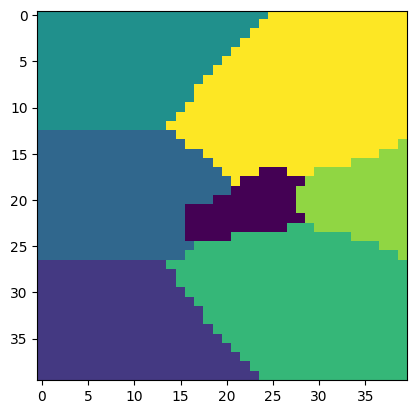

In [7]:
clf = svm.SVC(kernel='precomputed')
with open(file_path_train_DMRG, "rb") as f:
    dataset = pickle.load(f)

with h5py.File(file_path_kernel_train_DMRG, "r") as f:
    kernel_train = f[" gram_train_DMRG"][:] 

with h5py.File(file_path_kernel_test_DMRG, "r") as f:
    kernel_test = f["gram_test"][:] 

y = dataset[1]
clf.fit(kernel_train, y) 
y_pred = clf.predict(kernel_test)
plt.imshow(y_pred.reshape(40,40))
plt.savefig(f'result for DMRG states with L={L} and bond dimension ={bond}.png')
plt.show()

In [8]:
true_values = pd.read_csv('~/4th_project_with_UCL/scatter_points.csv')
y_true = true_values['target'].to_list()

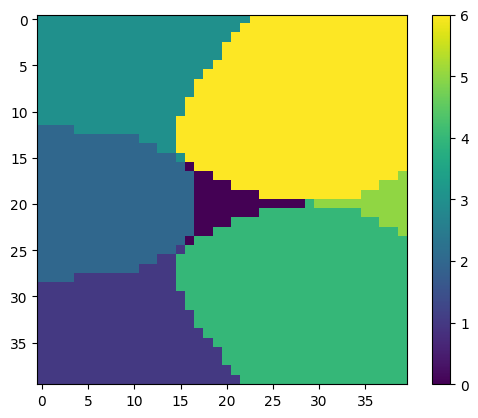

In [9]:
plt.imshow(np.array(y_true).reshape(40,40))
plt.colorbar()

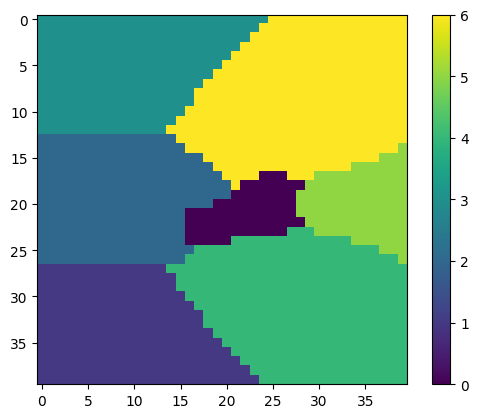

In [10]:
plt.imshow(y_pred.reshape(40,40))
plt.colorbar()

In [18]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)


0.8825

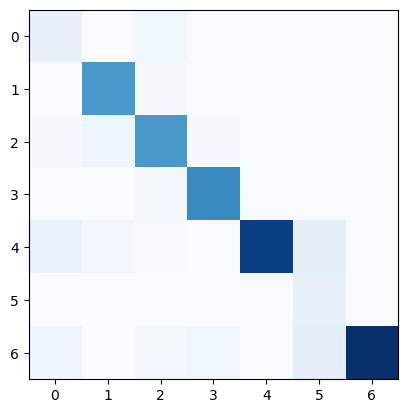

In [27]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_true, y_pred)
plt.imshow(mat, interpolation='nearest', cmap=plt.cm.Blues)

In [24]:
accuracy = np.trace(mat) / np.sum(mat)
accuracy

0.8825

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(y_true, y_pred, average='macro')  # or 'macro', 'micro', 'weighted'


0.7661007887248885

In [32]:
recall_score(y_true, y_pred, average='macro')


0.881388448279326

In [33]:
f1_score(y_true, y_pred, average='macro')

0.7881156344581617

In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.39      0.65      0.49        40
           1       0.89      0.98      0.93       219
           2       0.87      0.91      0.89       237
           3       0.93      0.97      0.95       242
           4       1.00      0.82      0.90       409
           5       0.29      1.00      0.44        28
           6       1.00      0.84      0.91       425

    accuracy                           0.88      1600
   macro avg       0.77      0.88      0.79      1600
weighted avg       0.93      0.88      0.90      1600



In [41]:
y_scores = clf.decision_function(kernel_test)  # Get the decision function scores
row_sums = y_scores.sum(axis=1, keepdims=True)
y_scores_normalized = y_scores / row_sums

In [43]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true, y_scores_normalized, multi_class='ovo')  # y_scores from `clf.decision_function(X)`

0.971818712271191

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_true):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


NameError: name 'n_classes' is not defined

In [10]:
projection = Haldan_anis(L = L, bond = bond).apply_projection()
file_path_train_projected_DMRG = os.path.join(path, 'train_set_projected_DMRG.pkl')
with open(file_path_train_projected_DMRG, "wb") as f:
    pickle.dump(projection, f)
gc.collect(2)

0

In [11]:
def gram_train_project_DMRG():

    with open(file_path_train_projected_DMRG, "rb") as f:
        loaded_dataset = pickle.load(f)

    gs = np.array(loaded_dataset[0])
    d = gs.shape[0]
    afinity_train = np.zeros((d,d))
    for i in range(0,d):
        for j in range(i,d):
            afinity_train[i,j] = np.abs(gs[i].H @ gs[j])**2
            afinity_train[j,i] = afinity_train[i,j]

    return afinity_train

g_train_proj = gram_train_project_DMRG()

file_path_kernel_projected_DMRG= os.path.join(path, "kernel_train_Haldane_projected_DMRG.hdf5")
with h5py.File(file_path_kernel_projected_DMRG, "w") as f:
    f.create_dataset(" gram_train_projected_DMRG", data = g_train_proj)
    
gc.collect(2)

0

In [12]:
def gram_test_projected_DMRG():

    with open(file_path_test, 'rb') as f:
        loaded_test_set = pickle.load(f)  
    Xte = np.array(loaded_test_set)
    d1 = Xte.shape[0]

    with open(file_path_train_projected_DMRG, "rb") as f:
        loaded_dataset = pickle.load(f)
    Xtr = np.array(loaded_dataset[0])
    d2 = Xtr.shape[0]
      
    gram_matrix_test = np.zeros((d1,d2))
    for i in range(d1):
        for j in range(d2):
            gram_matrix_test[i,j] = np.abs((Xte[i].H @ Xtr[j]))**2
    return gram_matrix_test

g_test_proj = gram_test_projected_DMRG()

file_path_kernel_test_projected_DMRG = os.path.join(path, "kernel_test_Haldane_projected_DMRG.hdf5")
with h5py.File(file_path_kernel_test_projected_DMRG, "w") as f:
    f.create_dataset("gram_test_projected_DMRG", data = g_test_proj)
gc.collect(2)


0

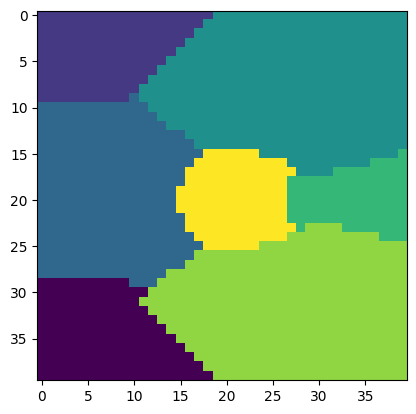

In [13]:
clf = svm.SVC(kernel='precomputed')
with open(file_path_train_projected_DMRG, "rb") as f:
    dataset = pickle.load(f)

with h5py.File(file_path_kernel_projected_DMRG, "r") as f:
    kernel_train = f[" gram_train_projected_DMRG"][:] 

with h5py.File(file_path_kernel_test_projected_DMRG, "r") as f:
    kernel_test = f["gram_test_projected_DMRG"][:] 

y = dataset[1]
clf.fit(kernel_train, y) 
y_pred = clf.predict(kernel_test)
plt.imshow(y_pred.reshape(40,40))
plt.savefig(f'result for projected DMRG states with L={L} and bond dimension ={bond}.png')
plt.show()